# Color transfer by optimal transport

In [1]:
import os
import warnings

warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt

from skimage.segmentation import mark_boundaries
from color_ot import Image, compute_transport_map, color_transfer

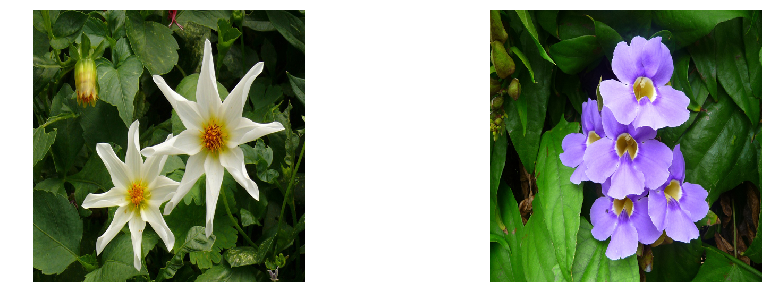

In [2]:
# image loading
u = Image('flower_1.jpg')
v = Image('flower_2.jpg')

# image display
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.imshow(u.array)
ax1.axis('off')

ax2.imshow(v.array)
ax2.axis('off');

In [3]:
# quantization
num_segments = 500

u.quantize(num_segments)
v.quantize(num_segments)

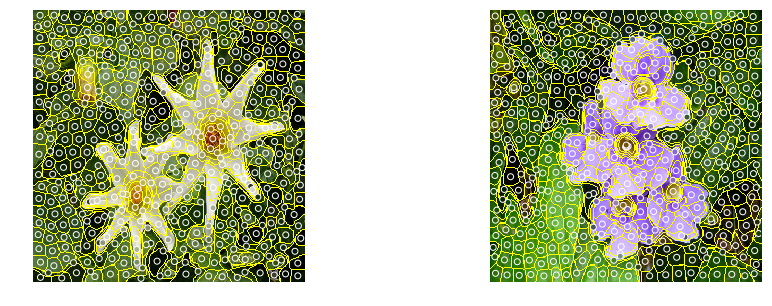

In [4]:
# clusters display
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.imshow(mark_boundaries(u.array, u.segments))

ax1.scatter([u.clusters[cluster_idx]['spatial_mean'][1] * u.array.shape[1] 
             for cluster_idx in range(len(u.clusters))],
            [u.clusters[cluster_idx]['spatial_mean'][0] * u.array.shape[0] 
             for cluster_idx in range(len(u.clusters))],
            facecolor=[u.clusters[cluster_idx]['color_mean'] 
                       for cluster_idx in range(len(u.clusters))],
            edgecolor='white')

ax1.axis('off')

ax2.imshow(mark_boundaries(v.array, v.segments))

ax2.scatter([v.clusters[cluster_idx]['spatial_mean'][1] * v.array.shape[1] 
             for cluster_idx in range(len(v.clusters))],
            [v.clusters[cluster_idx]['spatial_mean'][0] * v.array.shape[0] 
             for cluster_idx in range(len(v.clusters))],
            facecolor=[v.clusters[cluster_idx]['color_mean'] 
                       for cluster_idx in range(len(v.clusters))],
            edgecolor='white')

ax2.axis("off");

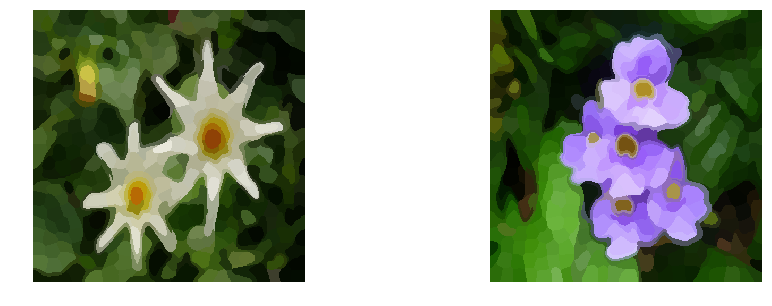

In [5]:
# quantized images display
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.imshow(u.quantized_array)
ax1.axis('off')

ax2.imshow(v.quantized_array)
ax2.axis("off");

In [6]:
# transport map computation
transport_map = compute_transport_map(u, v)

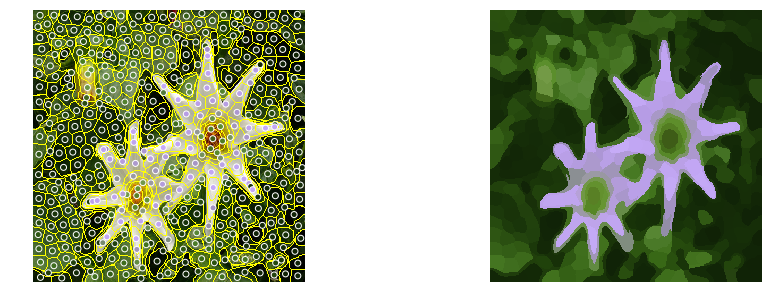

In [7]:
# color transfer result (super-pixel scale)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.imshow(mark_boundaries(u.array, u.segments))
ax1.scatter([u.clusters[cluster_idx]['spatial_mean'][1] * u.array.shape[1] 
            for cluster_idx in range(len(u.clusters))],
           [u.clusters[cluster_idx]['spatial_mean'][0] * u.array.shape[0] 
            for cluster_idx in range(len(u.clusters))],
           facecolor=[transport_map[cluster_idx] 
                      for cluster_idx in range(len(u.clusters))],
           edgecolor='white')
ax1.axis('off')

ax2.imshow(transport_map[u.segments])
ax2.axis('off');

In [8]:
# full color transfer
synthesized_image = color_transfer(u, v)

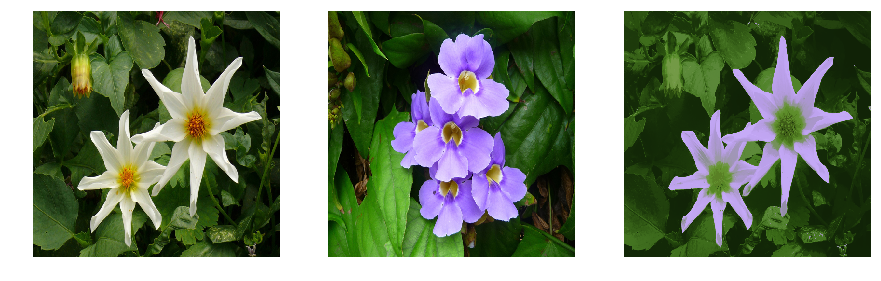

In [9]:
# color transfer result (original scale)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

ax1.imshow(u.array)
ax1.axis('off')

ax2.imshow(v.array)
ax2.axis('off')

ax3.imshow(synthesized_image)
ax3.axis('off');